## Forecasting - OLS, LASSO, PCA, Trees, Forests, Networks

In [1]:
# Import necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import plot_model

np.random.seed(0)

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

2024-09-24 14:24:14.272855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def neural_netork(input_dim):
  model = Sequential()
  
  model.add(Dense(16, input_shape=(input_dim,), activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(4, activation='relu'))

  # A single Dense layer (perceptron) with 1 unit and a linear activation function
  model.add(Dense(1, activation='linear'))

  # Compile the model
  # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error'
                )

  # Summary of the model to see its structure
  print(model.summary())

  return model

#### Retrieve the data

In [3]:
# Define the FRED path and local file path for the data
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
local_file_path = Path("data/current.csv")

# Load data from the local file if it exists; otherwise, load from FRED
if local_file_path.is_file():
    print("Local file found")
    df = pd.read_csv('data/current.csv')
else:
    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path)
    print("Done")
    
df.drop(0, inplace=True)

# Set the index to the date column and convert to datetime
df = df.set_index("sasdate", drop=True)
df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

# Preview the first few rows of the DataFrame
df.head()

Be patient: loading from FRED (2 minutes)
Done


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,283362.7075,18534.46600,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


#### Define the Target Variable (S&P 500 Returns)

In [4]:
df['Target'] = (np.log(df['S&P 500']) - np.log(df['S&P 500'].shift(1))).shift(1)
df.drop('S&P 500', axis=1, inplace=True)
df.dropna(inplace=True)
df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,Target
sasdate,,,,,,,,,,,,,,,,,,,,,
1992-02-01,8444.994,7290.1,49.123,718889.123,164213.0,61.9192,70.4258,68.6473,80.2867,57.8121,...,52.129,11.89,13.67,11.30,68.8,64066.00,189752.08,744.1547,17.0505,0.068559
1992-03-01,8457.388,7294.4,49.213,721782.597,163721.0,62.4403,71.0155,69.2529,81.0021,58.9931,...,52.284,11.92,13.76,11.32,76.0,62992.00,190887.95,749.5423,16.2227,-0.008496
1992-04-01,8487.783,7313.2,49.254,726592.639,164709.0,62.9199,71.5453,69.7742,81.7607,60.0895,...,52.481,11.96,13.77,11.36,77.2,64280.00,190911.80,756.0018,16.1885,-0.012684
1992-05-01,8531.932,7352.4,49.509,720270.973,165612.0,63.1268,71.9413,70.1855,82.2969,61.9726,...,52.543,11.97,13.77,11.39,79.2,62212.00,190975.14,765.6078,14.7280,0.000123
1992-06-01,8566.719,7384.2,49.643,727863.941,166077.0,63.1624,71.7638,69.9644,81.8938,61.1178,...,52.619,12.01,13.88,11.41,80.4,63021.00,192729.46,774.6433,14.7531,0.018001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,19194.730,15823.3,117.796,1523993.000,703256.0,102.6309,100.6803,100.8413,101.9747,107.7707,...,124.912,30.42,34.98,27.13,69.7,521938.91,921959.34,5092.0731,12.6960,0.043689
2024-01-01,19316.845,15862.4,117.385,1504491.000,695631.0,101.4830,99.9017,100.0648,101.2513,103.9426,...,125.804,30.57,35.30,27.21,79.0,525706.15,922805.11,5112.6320,13.3453,0.049214
2024-02-01,19307.749,15834.0,117.664,1509152.000,700519.0,102.7267,100.9719,100.9228,101.9449,107.5568,...,126.118,30.67,35.23,27.35,76.9,529015.93,921985.58,5112.3690,13.8808,0.027486


#### Creating training and test sets, standardizing the data

In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

In [6]:
scaler = StandardScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

#### Estimate the PCA model

In [7]:
# Initialize PCA
pca = PCA(n_components=3, whiten=True, svd_solver='full')

# Fit PCA on the training data
pca.fit(train_data_scaled.drop("Target", axis=1))

# Transform both train and test sets
train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

#### Forecasting Models

In [8]:
ols = LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1), train_data_scaled["Target"])
ols_pca = LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"])
lasso = Lasso(alpha=0.005, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1), train_data_scaled['Target'])

d_tree = DecisionTreeRegressor(max_depth=1000)
d_tree.fit(train_data_scaled.drop("Target", axis=1), train_data_scaled["Target"])

r_forest = RandomForestRegressor(max_depth=1000, random_state=0, n_estimators=2)
r_forest.fit(train_data_scaled.drop("Target", axis=1), train_data_scaled["Target"])

model = neural_netork(len(train_data_scaled.drop("Target", axis=1).columns))

history = model.fit(train_data_scaled.drop("Target", axis=1), 
                    train_data_scaled["Target"],
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1,
                    shuffle=False
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                2016      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2193 (8.57 KB)
Trainable params: 2193 (8.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
16/16 [==============================] - 2s 19ms/step - loss: 1.5483 - val_loss: 0.4710
Epoch 2/10
16/16 [==============================] - 

In [9]:
ols_forecasts = ols.predict(test_data_scaled.drop("Target", axis=1))
ols_pca_forecasts = ols_pca.predict(test_pca)
lasso_forecasts = lasso.predict(test_data_scaled.drop("Target", axis=1))
d_tree_forecasts = d_tree.predict(test_data_scaled.drop("Target", axis=1))
r_forest_forecasts = r_forest.predict(test_data_scaled.drop("Target", axis=1))
ann_forecasts = pd.Series(model.predict(test_data_scaled.drop("Target", axis=1)).flatten())

3/3 [==============================] - 0s 3ms/step


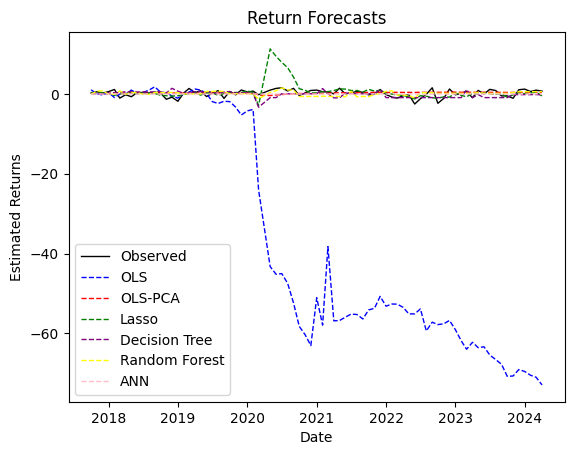

In [10]:
plt.figure()
plt.plot(test_data_scaled.index, test_data_scaled["Target"], linewidth=1, color='black', label='Observed')
plt.plot(test_data_scaled.index, ols_forecasts, '--', linewidth=1, color='blue', label='OLS')
plt.plot(test_data_scaled.index, ols_pca_forecasts, '--', linewidth=1, color='red', label='OLS-PCA')
plt.plot(test_data_scaled.index, lasso_forecasts, '--', linewidth=1, color='green', label='Lasso')
plt.plot(test_data_scaled.index, d_tree_forecasts, '--', linewidth=1, color='purple', label='Decision Tree')
plt.plot(test_data_scaled.index, r_forest_forecasts, '--', linewidth=1, color='yellow', label='Random Forest')
plt.plot(test_data_scaled.index, ann_forecasts, '--', linewidth=1, color='pink', label='ANN')
plt.title('Return Forecasts')
plt.xlabel('Date')
plt.ylabel('Estimated Returns')
plt.legend()

plt.show()

In [11]:

for i in [ols_forecasts, ols_pca_forecasts, lasso_forecasts, d_tree_forecasts, r_forest_forecasts,ann_forecasts]:
    print("MS and MA Errors:    ", mean_squared_error(test_data_scaled["Target"].values, i), "   ", mean_absolute_error(test_data_scaled["Target"].values, i))


MS and MA Errors:     2142.7485441436693     36.768189962353155
MS and MA Errors:     0.883028974400747     0.728526779304693
MS and MA Errors:     4.036419910058569     1.1067223477685224
MS and MA Errors:     1.2418944773804264     0.8626124341392671
MS and MA Errors:     0.9128445587930412     0.7714659672884413
MS and MA Errors:     0.8050366515951459     0.7355322639864661


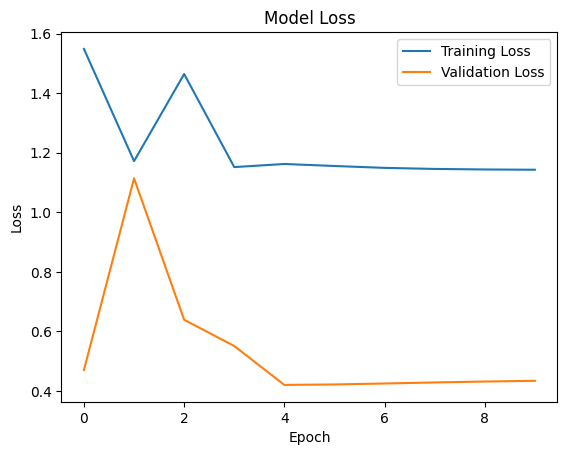

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Things to consider:

* Suggested data transformation `TCODE' should be applied for each series before fitting the model.
* Expanding window / rolling window regressions to re-estimate the models on recent data. How many observations should the initial window contain? 
* Split the training data into training and validation subsets, to tune the Lasso lambda hyperparameter. What validation methodology should be used: simple holdout, cross-validation, etc.? What should the training-validation split be?
* Selection of optimal PCs in expanding window / rolling window regressions.
* etc.
